In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler

# Step 1: Generate Data from a Multivariate Normal Distribution with a Linear Relationship to Y
def generate_linear_data_with_cov(n_samples, n_features, cov_matrix=None, true_coef= None, noise_std=1.0):
    if cov_matrix is None:
        # Generate a random positive-definite covariance matrix if not provided
        A = np.random.randn(n_features, n_features)
        cov_matrix = np.dot(A, A.T)  # This ensures the covariance matrix is positive-definite

    # Generate the feature matrix X from a multivariate normal distribution
    mean = np.zeros(n_features)  # Assume zero mean for all features
    X = np.random.multivariate_normal(mean, cov_matrix, size=n_samples)
    
    X = np.c_[np.ones(n_samples), X]  # Add a column of ones for the intercept term
    
    # Generate true coefficients for the linear relationship
    if true_coef is None:
        true_coef = np.random.randint(-10, 10, size=n_features + 1)

    # Generate target variable Y as a linear combination of X plus noise
    noise = noise_std * np.random.randn(n_samples)
    y = X @ true_coef + noise  # Linear relation: Y = X*beta + noise

    return X, y, true_coef, cov_matrix

In [199]:
# Step 2: LASSO Regression with Correct Shrinkage Factor Calculation
def lasso_regression_analysis(X, y, num_alphas=1000):
    np.random.seed(0)  # For reproducibility

    # Step 2a: Set up a range of alpha values (shrinkage parameters)
    alphas = np.linspace(0.01, 10, num_alphas)

    # Store L1 norms of coefficients (t) and the corresponding coefficients
    t_values = []
    lasso_coefs = []
    ssrs = []

    for alpha in alphas:
        # Step 2b: Perform LASSO regression for the current alpha
        lasso = Lasso(alpha=alpha, fit_intercept=True)
        lasso.fit(X, y)
        
        ssr = np.sum((y - lasso.predict(X))**2)
        
        # Step 2c: Calculate L1 norm of the coefficients (this is t)
        coef_l1_norm = np.sum(np.abs(lasso.coef_))
        
        # Store the L1 norm (t) and the coefficients
        t_values.append(coef_l1_norm)
        lasso_coefs.append(lasso.coef_)
        ssrs.append(ssr)

    lasso_coefs = np.array(lasso_coefs)
    t_values = np.array(t_values)

    # Step 3: Sort coefficients and t values in order of increasing t
    sorted_indices = np.argsort(t_values)
    t_values_sorted = t_values[sorted_indices]
    lasso_coefs_sorted = lasso_coefs[sorted_indices]
    alphas_sorted = alphas[sorted_indices]
    ssrs_sorted = np.array(ssrs)[sorted_indices]
    
    return t_values_sorted, lasso_coefs_sorted, alphas_sorted, ssrs_sorted

True coefficients used to generate Y: [5 7 7]
Covariance matrix used to generate X:
 [[1.   0.95]
 [0.95 1.  ]]
OLS Coefficients: [0.         6.84970327 7.16328629]


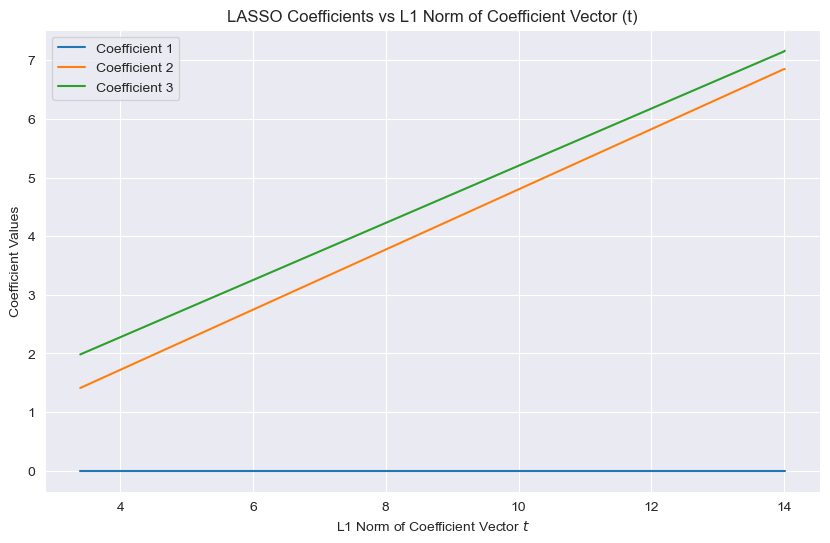

In [200]:
# Example usage
n_samples = 1000  # Number of samples (data points)
n_features = 2   # Number of features (dimensions)

cov_matrix = np.eye(n_features)
cov_matrix[0, 1] = 0.95
cov_matrix[1, 0] = cov_matrix[0, 1] 

# Step 1: Generate data with a linear relationship between X and Y, using a random covariance matrix
true_coef = np.array([5, 7, 7])  # Coefficients for the linear relationship
X, y, true_coef, cov_matrix = generate_linear_data_with_cov(n_samples, n_features, cov_matrix= cov_matrix, true_coef=true_coef)

# Display the true coefficients and covariance matrix
print("True coefficients used to generate Y:", true_coef)
print("Covariance matrix used to generate X:\n", cov_matrix)

# Perform LASSO analysis with shrinkage, plotting coefficients against L1 norm (t)
t_values_sorted, lasso_coefs_sorted, alphas_sorted, ssrs_sorted = lasso_regression_analysis(X, y)

# Calcualte OLS regression
ols = LinearRegression(fit_intercept=True)
ols.fit(X, y)
ols_coef = ols.coef_
print("OLS Coefficients:", ols_coef)

ssr_ols = np.sum((y - ols.predict(X))**2)

t0 = np.sum(np.abs(ols_coef))
ts = np.append(t_values_sorted, t0)
ssrs_sorted = np.append(ssrs_sorted, ssr_ols)

coefficients = np.vstack([lasso_coefs_sorted, ols_coef])

# Step 4: Plot the L1 norm (t) vs LASSO coefficient values for each feature
plt.figure(figsize=(10, 6))
for i in range(lasso_coefs_sorted.shape[1]):
    plt.plot(ts, coefficients[:, i], label=f"Coefficient {i+1}")
plt.xlabel(r"L1 Norm of Coefficient Vector $t$")
plt.ylabel("Coefficient Values")
plt.title("LASSO Coefficients vs L1 Norm of Coefficient Vector (t)")
plt.legend()
plt.grid(True)
plt.show()

Covariance matrix used to generate X:
 -0.9


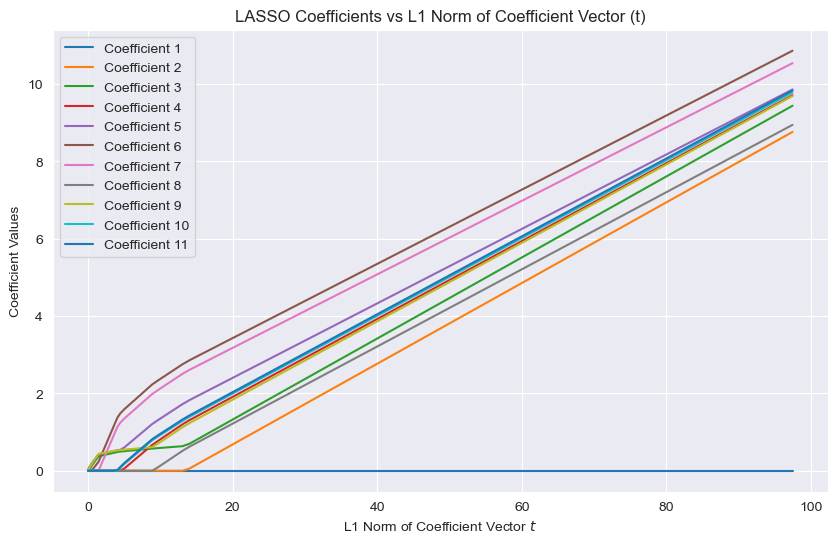

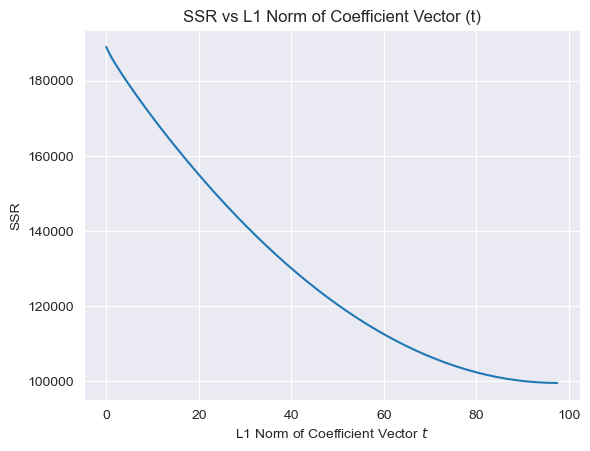

Covariance matrix used to generate X:
 -0.45


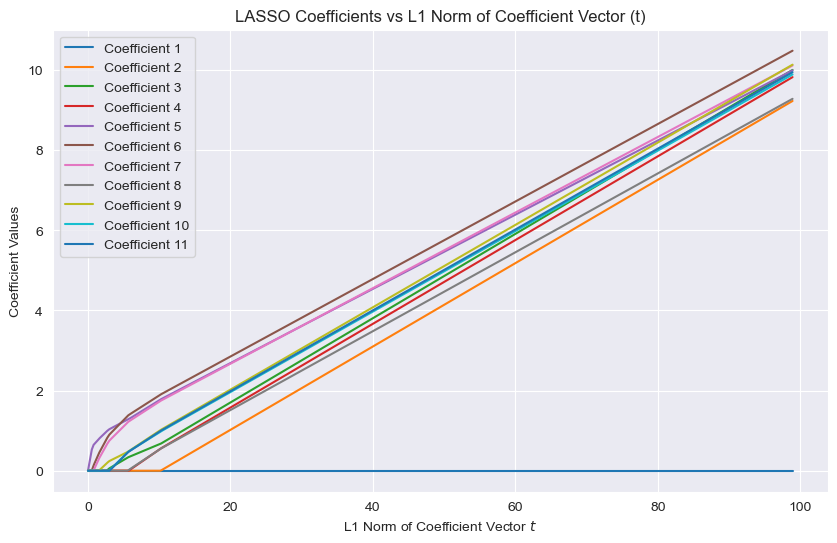

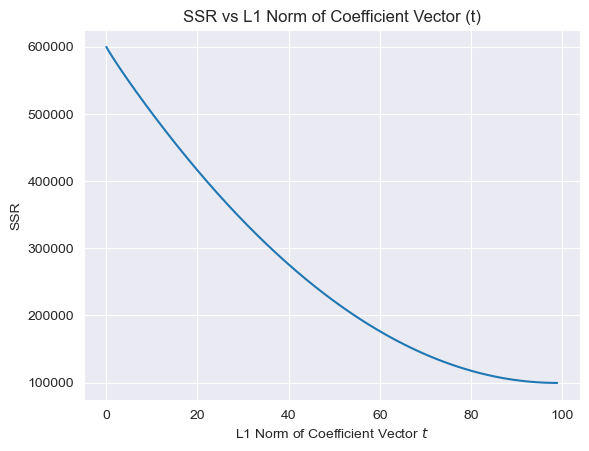

Covariance matrix used to generate X:
 0.0


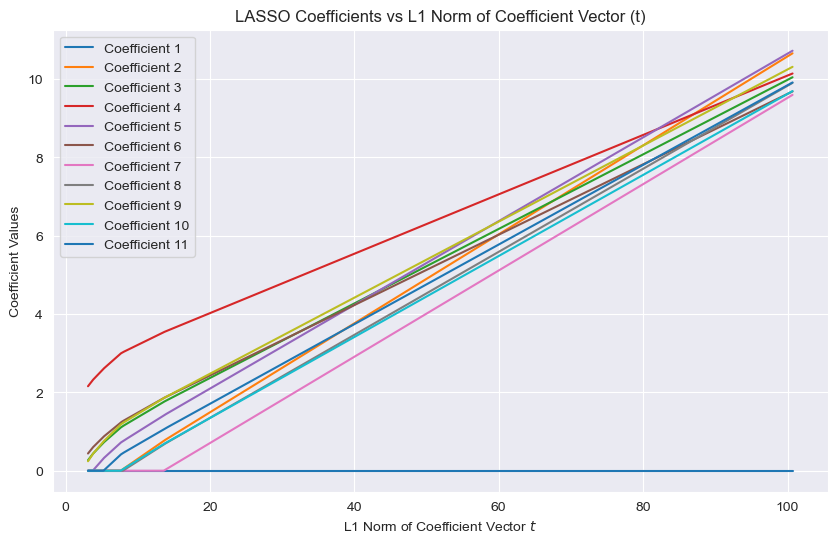

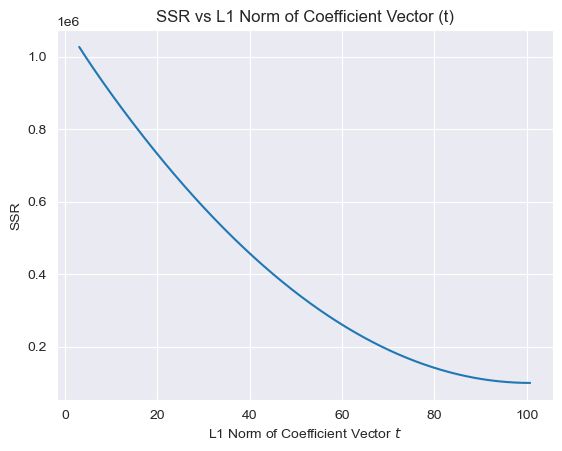

Covariance matrix used to generate X:
 0.45000000000000007


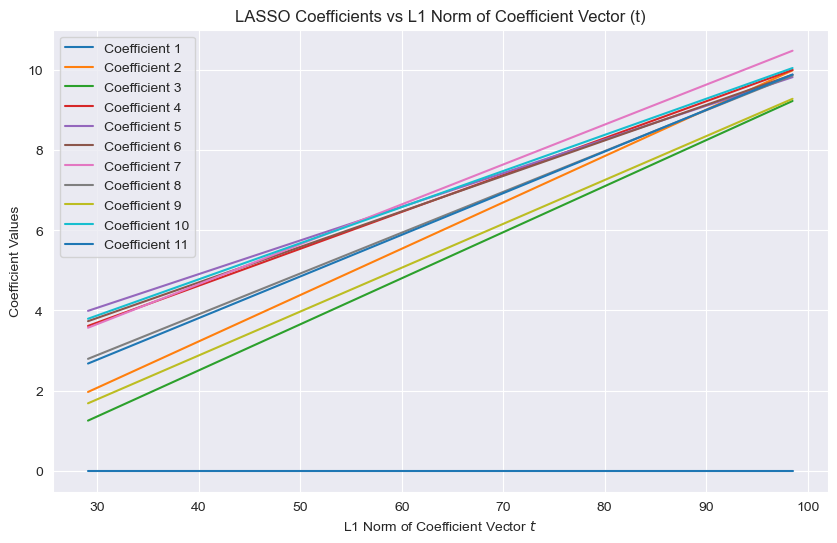

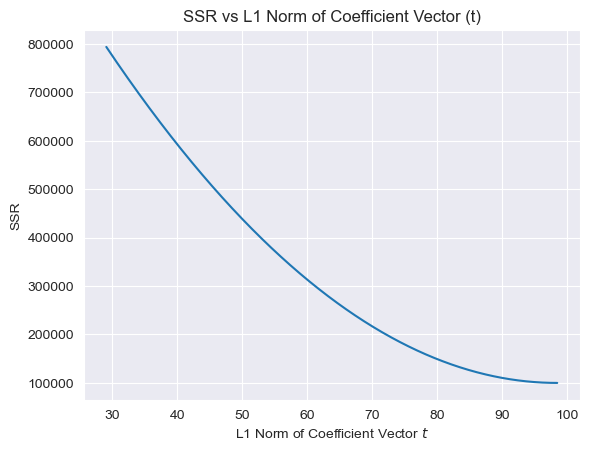

Covariance matrix used to generate X:
 0.9


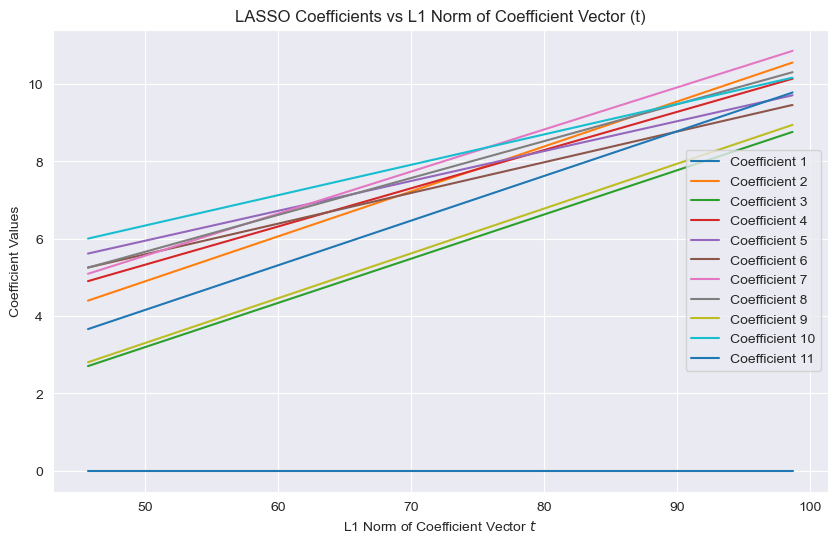

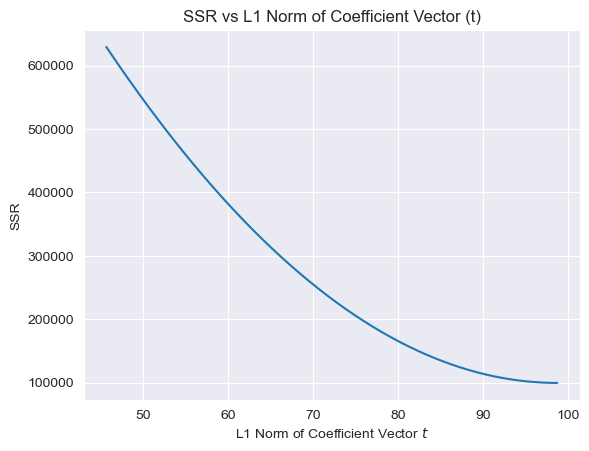

In [201]:
rhos = np.linspace(-0.9, 0.9, 5)
n_features = 10
n_samples = 1000

def generate_pairwise_cov_matrix(n_pairs, correlation=0.8):
    # Initialize an empty matrix
    n_features = 2 * n_pairs
    cov_matrix = np.zeros((n_features, n_features))
    
    # Create 2x2 blocks for each correlated pair
    block = np.array([[1, correlation], [correlation, 1]])
    
    # Fill in the block diagonal with the pairwise correlated blocks
    for i in range(n_pairs):
        cov_matrix[2*i:2*i+2, 2*i:2*i+2] = block
    
    return cov_matrix

for rho in rhos:
    cov_matrix = generate_pairwise_cov_matrix(n_pairs=int(n_features/2), correlation=rho)
    # cov_matrix[2, 3] = rho
    # cov_matrix[3, 2] = cov_matrix[2, 3]
    
    # Step 1: Generate data with a linear relationship between X and Y, using a random covariance matrix
    true_coef = [10] * (n_features+1)  # Coefficients for the linear relationship
    X, y, true_coef, cov_matrix = generate_linear_data_with_cov(n_samples, n_features, cov_matrix= cov_matrix, true_coef=true_coef, noise_std=10.0)
    
    # Display the true coefficients and covariance matrix
    print("Covariance matrix used to generate X:\n", rho)
    
    # Perform LASSO analysis with shrinkage, plotting coefficients against L1 norm (t)
    t_values_sorted, lasso_coefs_sorted, alphas_sorted, ssrs_sorted = lasso_regression_analysis(X, y)
    
    # Calcualte OLS regression
    ols = LinearRegression(fit_intercept=True)
    ols.fit(X, y)
    ols_coef = ols.coef_
    
    t0 = np.sum(np.abs(ols_coef))
    ts = np.append(t_values_sorted, t0)
    ssr_ols = np.sum((y - ols.predict(X))**2)
    ssrs_sorted = np.append(ssrs_sorted, ssr_ols)
    
    coefficients = np.vstack([lasso_coefs_sorted, ols_coef])
    
    # Step 4: Plot the L1 norm (t) vs LASSO coefficient values for each feature
    plt.figure(figsize=(10, 6))
    for i in range(lasso_coefs_sorted.shape[1]):
        plt.plot(ts, coefficients[:, i], label=f"Coefficient {i+1}")
    plt.xlabel(r"L1 Norm of Coefficient Vector $t$")
    plt.ylabel("Coefficient Values")
    plt.title("LASSO Coefficients vs L1 Norm of Coefficient Vector (t)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.plot(ts, ssrs_sorted)
    plt.xlabel(r"L1 Norm of Coefficient Vector $t$")
    plt.ylabel("SSR")
    plt.title("SSR vs L1 Norm of Coefficient Vector (t)")
    plt.grid(True)
    plt.show()